In [1]:
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns

In [2]:
sns.set_style("darkgrid")
figsize = (16, 6)
urlfile = r'https://covid.ourworldindata.org/data/owid-covid-data.csv'

In [17]:
# вспомогательные функции из лекций

def bayesian_update(mu, sigma, x, y, sigma_noise):
    x_matrix = np.array([[1] + [i for i in x]])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]) ) )
    return mu_n, sigma_n

def myplot_heatmap(Z):
    # Make the plot
    plt.axis('equal')
    plt.xlim((-1, 1))
    plt.ylim((-1, 1))
    plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet)
    plt.scatter(true_mu[0], true_mu[1], marker='*', s=120)
    
def myplot_sample_lines(mu, sigma, n=20, points=None):
    # Посэмплируем и порисуем прямые
    my_w = np.random.multivariate_normal(mu, sigma, n)

    # plt.axis('equal')
    for w in my_w:
        plt.plot(xs, w[0] + w[1]*xs, 'k-', lw=.4)
    plt.ylim((-3, 3))
    plt.xlim((-3, 3))
    if not points is None:
        plt.scatter(points[0], points[1], marker='*', s=200)
        
def sample_statistics(mu, sigma, xs, n=20):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    res = np.zeros((n, xs.shape[0]))
    for i,w in enumerate(my_w):
        res[i,:] = w[0] + w[1]*xs
    return res

def plot_predictions(xs, mu, x, points):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.set_xlim((xs[0], xs[-1]))
    ax.set_ylim((-2, 2))
    ax.plot(xs, true_curve(xs), label="Правильный ответ")
    ax.plot(xs, mu[1]*xs + mu[0], color="red", label="MAP гипотеза")
    ax.fill_between(xs, mu[1]*xs + mu[0] - .25, mu[1]*xs + mu[0] + .25, color=palette[1], alpha=.3, label="+- дисперсия шума")
    ax.fill_between(xs, np.mean(x, axis=0) - np.std(x, axis=0), np.mean(x, axis=0) + np.std(x, axis=0), color=palette[5], alpha=.2, label="+- дисперсия предсказаний")
    ax.scatter(points[0], points[1], marker='*', s=200)
    ax.legend(fontsize=legend_fontsize)

In [3]:
data = pd.read_csv(urlfile)
df = data[(data['location'] == 'Russia') & (data['date'] >= '2020-03-03')].reset_index()
df['new_cases'] = df['new_cases'].apply(lambda x: x if (x != 0) else 1)
train_feat = np.arange(50)
test_feat = np.arange(50, len(df))
full_feat = np.arange(len(df))

Построение графиков

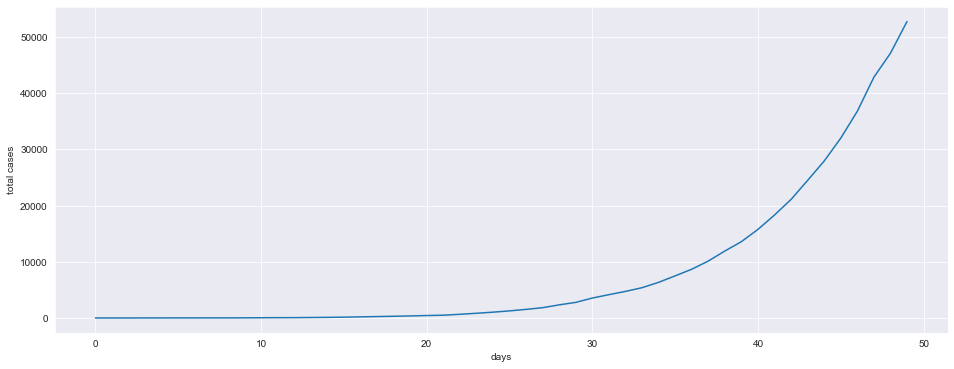

In [4]:
# TOTAL CASES
plt.figure(figsize=figsize)
df.iloc[:50].total_cases.plot()
plt.xlabel("days")
plt.ylabel("total cases")
plt.show()

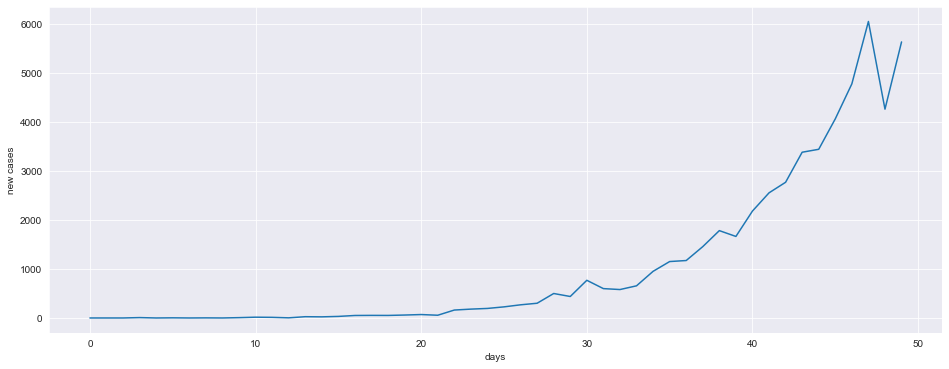

In [5]:
# NEW CASES
plt.figure(figsize=figsize)
df.iloc[:50].new_cases.plot()
plt.xlabel("days")
plt.ylabel("new cases")
plt.show()

Линейная регрессия

In [6]:
train_feat = np.arange(50)
test_feat = np.arange(50, len(df))
full_feat = np.arange(len(df))

In [7]:
regression = LinearRegression().fit(train_feat.reshape(-1, 1), np.log(df.total_cases[train_feat]))
pred = np.exp(regression.predict(full_feat.reshape(-1, 1)))

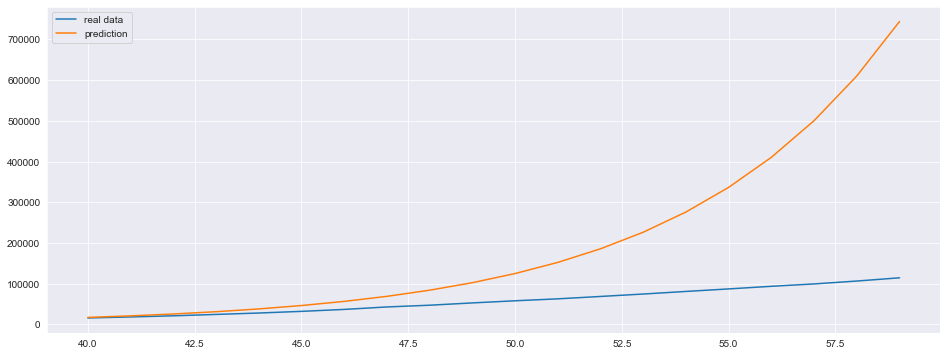

In [18]:
upper_bounder = 60
lower_bounder = 40
plt.figure(figsize=figsize)
plt.plot(full_feat[lower_bounder:bounder], df.total_cases[full_feat[lower_bounder:bounder]], label='real data')
plt.plot(full_feat[lower_bounder:bounder], pred[lower_bounder:bounder], label='prediction')
plt.legend(loc='best')
plt.show()

In [12]:
regression1 = LinearRegression().fit(train_feat.reshape(-1, 1), np.log(df.new_cases[train_feat]))
pred1 = np.exp(regression.predict(full_feat.reshape(-1, 1)))

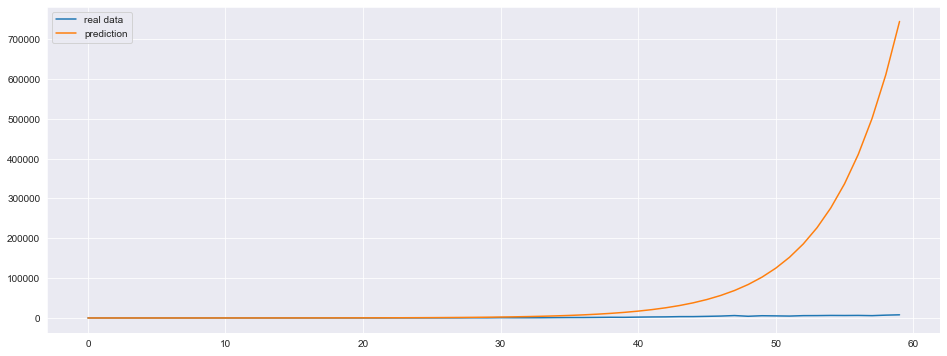

In [19]:
upper_bounder = -1
lower_bounder = 0
plt.figure(figsize=figsize)
plt.plot(full_feat[lower_bounder:bounder], df.new_cases[full_feat[lower_bounder:bounder]], label='real data')
plt.plot(full_feat[lower_bounder:bounder], pred1[lower_bounder:bounder], label='prediction')
plt.legend(loc='best')
plt.show()

2.b) Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели (это фактически первый шаг эмпирического Байеса).

In [30]:
[prev_coef], prev_inter = regression.coef_, regression.intercept_
total_sigma = (np.log(df.total_cases[train_feat]) - np.log(pred[train_feat])).std()

In [43]:
mu, sigma = np.array([0, 0]), np.array([[1, 0], [0, 1]])
for i in range(50):
    mu, sigma = bayesian_update(
                            mu=mu, 
                            sigma=sigma, 
                            x=np.array([i]), 
                            y=np.log(pred[i]), 
                            sigma_noise=total_sigma)

In [47]:
# Параметры апостериорного распределения
mu[0], mu[1]

(1.8033875048303687, 0.1988160477142336)

In [55]:
sigma

array([[ 9.56046338e-03, -2.89710121e-04],
       [-2.89710121e-04,  1.18543036e-05]])

2.с) Посэмплируйте много разных экспонент, постройте графики. Сколько, исходя
из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая? к
1 июня? к 1 сентября? Постройте предсказательные распределения (можно
эмпирически, исходя из данных сэмплирования)

In [73]:
may_sample = sample_statistics(mu, sigma, np.arange(60), n=500) # май
june_sample = sample_statistics(mu, sigma, np.arange(90), n=500) # июнь
september_sample = sample_statistics(mu, sigma, np.arange(180), n=500) # сентябрь

In [76]:
# среднее по семплу против реального значения
# май
np.exp(np.mean(may_sample, axis=0)[-1]), df.total_cases.iloc[60]

(756037.978977178, 124054.0)

In [77]:
# июнь
np.exp(np.mean(june_sample, axis=0)[-1]), df.total_cases.iloc[90]

(287902503.335696, 414328.0)

In [78]:
# июнь
np.exp(np.mean(september_sample, axis=0)[-1]), df.total_cases.iloc[180]

(1.790366858716064e+16, 987470.0)

Видим, что предсказания сильно разняться с реальными данными на промежутке, дальше тренировочного

3.а) Предложите способ обучать параметры такой сигмоидальной функции при помощи линейной регрессии.

Так как в экспоненте находится квадратичная функция, можем добавить в признаки  $x^2$ и работать только с new_cases.

Для получения total cases можем взять коммулитивную сумму.

3.b. Обучите эти параметры на датасете случаев коронавируса в России. Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели.

In [82]:
train_feat ** 2

array([   0,    1,    4,    9,   16,   25,   36,   49,   64,   81,  100,
        121,  144,  169,  196,  225,  256,  289,  324,  361,  400,  441,
        484,  529,  576,  625,  676,  729,  784,  841,  900,  961, 1024,
       1089, 1156, 1225, 1296, 1369, 1444, 1521, 1600, 1681, 1764, 1849,
       1936, 2025, 2116, 2209, 2304, 2401])

In [102]:
train = np.stack(train_feat, train_feat ** 2)
full = np.stack(full_feat, full_feat ** 2)

TypeError: only integer scalar arrays can be converted to a scalar index

In [95]:
# train = train.reshape(2, len(train))
# full = full.reshape(2, len(full))

ValueError: cannot reshape array of size 100 into shape (2,2)

In [97]:
train.shape

(2, 1, 50)

In [101]:
regression = LinearRegression().fit(train, np.log(df.new_cases[train_feat]))
pred = np.exp(regression.predict(full.T))

ValueError: Found array with dim 3. Estimator expected <= 2.